# Chapter 5
# Numerical Integration and Differentiation

In many computational economic applications, one must compute the definite integral
of a real-valued function f with respect to a "weighting" function w over an interval
$I$ of $R^n$:

$$\int_I f(x)w(x) dx$$


The weighting function may be the identity, $w = 1$, in which case the integral represents
the area under the function f. In other applications, w may be the probability
density of a random variable $\tilde X$
, in which case the integral represents the expectation
of $f( \tilde X)$ when $I$ repesents the whole support of $\tilde X$.





In this chapter, we discuss three classes of numerical integration or numerical
quadrature methods<sup>1</sup>. All methods approximate the integral with a weighted sum of
function values:

$$\int_I f(x) w(x)dx \approx \sum_{i=0}^{n} w_i f(x_i)\thinspace .$$

<sup>1</sup>Quadrature is a historical mathematical term that means calculating area. 

The methods differ only in how the *quadrature weights* $wi$ and the *quadrature nodes*
$xi$ are chosen.

1. Newton-Cotes rules employ piecewise polynomial approximations to the integrand
2. Gaussian quadrature methods employ nodes and weights that satisfy moment matching conditions
3. Monte Carlo methods employ equally weighted “random” nodes

**Newton-Cotes** methods approximate the integrand f between nodes
using low order polynomials, and sum the integrals of the polynomials to estimate
the integral of f. Newton-Cotes methods are easy to implement, but are not particularly
eÆcient for computing the integral of a smooth function.

**Gaussian quadrature**
methods choose the nodes and weights to satisfy moment matching conditions, and
are more powerful than Newton-Cotes methods if the integrand is smooth.

**Monte Carlo and quasi-Monte Carlo integration** methods use "random" or "equidistributed"
nodes, and are simple to implement and are especially useful if the integration domain
is of high dimension or irregularly shaped.


In this chapter, we also present an overview of how to compute *finite difference*
approximations for the derivatives of a real-valued function. 

As we have seen in
previous chapters, it is often desirable to compute derivatives numerically because
analytic derivative expressions are difficult or impossible to derive, or expensive to
evaluate. 

Finite difference methods can also be used to solve differential equations,
which arise frequently in dynamic economic models, especially models formulated in
continuous time. In this chapter, we introduce numerical methods for differential
equations and illustrate their application to *initial value problems*.

In [1]:
# https://github.com/QuantEcon/QuantEcon.py/blob/488b7b3b9117cfd9bfc71c187efc87c39fc5b459/quantecon/quad.py
"""
Filename: quad.py
Authors: Chase Coleman, Spencer Lyon
Date: 2014-07-01
Defining various quadrature routines.
Based on the quadrature routines found in the CompEcon toolbox by
Miranda and Fackler.
References
----------
Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
and Finance, MIT Press, 2002.
"""

from __future__ import division

import math
import numpy as np
import scipy.linalg as la
from scipy.special import gammaln
import sympy as sym
#from .ce_util import ckron, gridmake


%matplotlib notebook

import matplotlib.pyplot as plt

from functools import reduce

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def ckron(*arrays):
    """
    Repeatedly applies the np.kron function to an arbitrary number of
    input arrays
    Parameters
    ----------
    *arrays : tuple/list of np.ndarray
    Returns
    -------
    out : np.ndarray
        The result of repeated kronecker products
    Notes
    -----
    Based of original function `ckron` in CompEcon toolbox by Miranda
    and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return reduce(np.kron, arrays)

def gridmake(*arrays):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if all([i.ndim == 1 for i in arrays]):
        d = len(arrays)
        if d == 2:
            out = _gridmake2(*arrays)
        else:
            out = _gridmake2(arrays[0], arrays[1])
            for arr in arrays[2:]:
                out = _gridmake2(out, arr)

        return out
    else:
        raise NotImplementedError("Come back here")

        
def _gridmake2(x1, x2):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake2`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if x1.ndim == 1 and x2.ndim == 1:
        return np.column_stack([np.tile(x1, x2.shape[0]),
                               np.repeat(x2, x1.shape[0])])
    elif x1.ndim > 1 and x2.ndim == 1:
        first = np.tile(x1, (x2.shape[0], 1))
        second = np.repeat(x2, x1.shape[0])
        return np.column_stack([first, second])
    else:
        raise NotImplementedError("Come back here")        

def _qnwtrap1(n, a, b):
    """
    Compute univariate trapezoid rule quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwtrap1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n < 1:
        raise ValueError("n must be at least one")

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]

    weights = dx * np.ones(n)
    weights[0] *= 0.5
    weights[-1] *= 0.5

    return nodes, weights
        

def _qnwsimp1(n, a, b):
    """
    Compute univariate Simpson quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwsimp1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n % 2 == 0:
        print("WARNING qnwsimp: n must be an odd integer. Increasing by 1")
        n += 1

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]
    weights = np.tile([2.0, 4.0], (n + 1) // 2)
    weights = weights[:n]
    weights[0] = weights[-1] = 1
    weights = (dx / 3.0) * weights

    return nodes, weights    
    
        
def _qnwlege1(n, a, b):
    """
    Compute univariate Guass-Legendre quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwlege1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    # import ipdb; ipdb.set_trace()
    maxit = 100
    m = np.fix((n + 1) / 2.0).astype(int)
    xm = 0.5 * (b + a)
    xl = 0.5 * (b - a)
    nodes = np.zeros(n)

    weights = nodes.copy()
    i = np.arange(m, dtype='int')

    z = np.cos(np.pi * ((i + 1.0) - 0.25) / (n + 0.5))

    for its in range(maxit):
        p1 = 1.0
        p2 = 0.0
        for j in range(1, n+1):
            p3 = p2
            p2 = p1
            p1 = ((2 * j - 1) * z * p2 - (j - 1) * p3) / j

        pp = n * (z * p1 - p2)/(z * z - 1.0)
        z1 = z.copy()
        z = z1 - p1/pp
        if all(np.abs(z - z1) < 1e-14):
            break

    if its == maxit - 1:
        raise ValueError("Maximum iterations in _qnwlege1")

    nodes[i] = xm - xl * z
    nodes[- i - 1] = xm + xl * z

    weights[i] = 2 * xl / ((1 - z * z) * pp * pp)
    weights[- i - 1] = weights[i]

    return nodes, weights





        
def _make_multidim_func(one_d_func, n, *args):
    """
    A helper function to cut down on code repetition. Almost all of the
    code in qnwcheb, qnwlege, qnwsimp, qnwtrap is just dealing
    various forms of input arguments and then shelling out to the
    corresponding 1d version of the function.
    This routine does all the argument checking and passes things
    through the appropriate 1d function before using a tensor product
    to combine weights and nodes.
    Parameters
    ----------
    one_d_func : function
        The 1d function to be called along each dimension
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    args :
        These are the arguments to various qnw____ functions.  For the
        majority of the functions this is just a and b, but some differ.
    Returns
    -------
    func : function
        The multi-dimensional version of the parameter ``one_d_func``
    """
    args = list(args)
    n = np.asarray(n)
    args = list(map(np.asarray, args))

    if all([x.size == 1 for x in [n] + args]):
        return one_d_func(n, *args)

    d = n.size

    for i in range(len(args)):
        if args[i].size == 1:
            args[i] = np.repeat(args[i], d)

    nodes = []
    weights = []

    for i in range(d):
        ai = [x[i] for x in args]
        _1d = one_d_func(n[i], *ai)
        nodes.append(_1d[0])
        weights.append(_1d[1])

    weights = ckron(*weights[::-1])  # reverse ordered tensor product

    nodes = gridmake(*nodes)
    return nodes, weights    

## 5.1 Newton-Cotes Methods




reference: 


https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/newton-cotes.ipynb

Newton-Cotes quadrature methods are designed to approximate the integral of a realvalued
function $f$ defined on a bounded interval $[a; b]$ of the real line. Newton-Cotes
methods approximate the integrand $f$ between nodes using *low order polynomials*,
and sum the integrals of the polynomials to form an estimate the integral of f. 

Two
Newton-Cotes rules are widely used in practice: the **trapezoid rule and Simpson's
rule**. Both rules are very easy to implement and are typically adequate for computing
the area under a continuous function.

1. Trapezoid rule (based on piecewise linear approximation) 
2. Simpson’s rule (based on piecewise quadratic approximation)

### Trapezoid Rule

![](http://mathworld.wolfram.com/images/eps-gif/TrapezoidalRule_1000.gif)

http://mathworld.wolfram.com/Newton-CotesFormulas.html

https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas

The trapezoid rule partitions the interval [a; b] into subintervals of equal length, approximates
f over each subinterval using linear interpolants, and then sums the areas under the
linear segments. The trapezoid rule draws its name from the fact that the area under f is
approximated by a series of trapezoids.

$$\int \limits_{x_i}^{x_{i+1}} f \, (x) \, d x \approx \frac{h}{2} \left[ f(x_i) + f(x_{i+1})  \right]\: .$$

where $x_i = a + (i-1)h$, with $h$ (called the step size) equal to   $ h=(b − a) / (n-1)$. The $w_i$ are called weights.

$$\int _{a}^{b}f(x)\,dx\approx \sum _{{i=1}}^{{n-1}}w_{i}\,f(x_{i}).$$


where $w_1 = w_n = h/2$ and $w_i = h$, otherwise.


1.	Compute the function values $f(x_{i})$	at the nodes
2.	Form a piecewise linear approximation $\tilde f$ of $f$ 	by connecting successive points $(x_i,y_i)$ on the graph of $f$	with straight lines
3.	The area under $f$  is then approximated by the area under $\tilde f$ , which consists of a series of trapezoids, giving the trapezoid rule its name


## Example 

First, we define a simple function and sample it between 0 and 10 at 200 points


reference:

http://nbviewer.jupyter.org/github/sbustamante/ComputationalMethods/blob/master/material/numerical-calculus.ipynb#Numerical-Differentiation

https://github.com/ipython/ipython/blob/master/examples/IPython%20Kernel/Trapezoid%20Rule.ipynb

In [3]:
#Quadrature method
def Quadrature( f, X, xmin, xmax, ymin=0, ymax=1, fig=None, leg=True ):
    #f(x_i) values
    Y = f( X )
    
    #X array
    Xarray = np.linspace( xmin, xmax, 1000 )
    #X area
    Xarea = np.linspace( X[0], X[-1], 1000 )
    #F array
    Yarray = f( Xarray )
    
    #Lagrange polynomial
    Ln = interp.lagrange( X, Y )
    #Interpolated array
    Parray = Ln( Xarray )
    #Interpolated array for area
    Parea = Ln( Xarea )
    
    #Plotting
    if fig==None:
        fig = plt.figure( figsize = (8,8) )
    ax = fig.add_subplot(111)
    #Function
    ax.plot( Xarray, Yarray, linewidth = 3, color = "blue", label="$f(x)$" )
    #Points
    ax.plot( X, Y, "o", color="red", label="points", zorder = 10 )
    #Interpolator
    ax.plot( Xarray, Parray, linewidth = 2, color = "black", label="$P_{%d}(x)$"%(len(X)-1) )
    #Area
    ax.fill_between( Xarea, Parea, color="green", alpha=0.5 )
    
    #Format
    ax.set_title( "%d-point Quadrature"%(len(X)), fontsize=16 )
    ax.set_xlim( (xmin, xmax) )
    ax.set_ylim( (0, 4) )
    ax.set_xlabel( "$x$" )
    ax.set_ylabel( "$y$" )
    if leg:
        ax.legend( loc="upper left", fontsize=16 )
    ax.grid(1)
    
    return ax

<IPython.core.display.Javascript object>


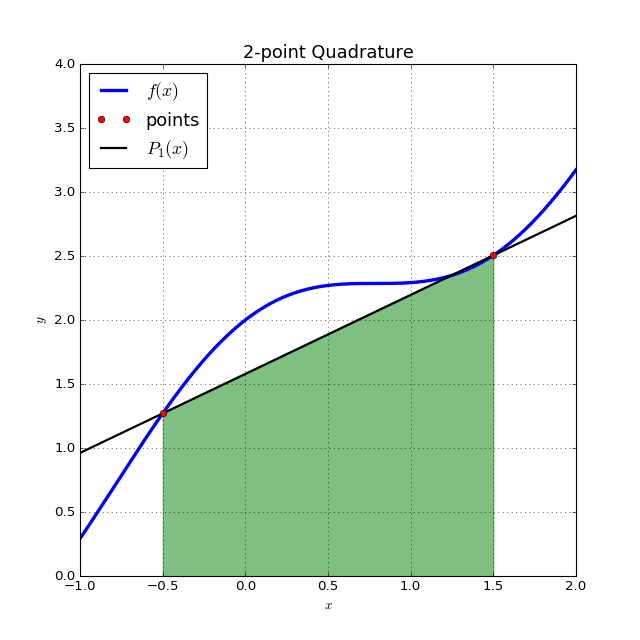

In [4]:
#Function
def f(x):
    return 1+np.cos(x)**2+x

# Choose a region to integrate over and take only a few points in that region
#Quadrature with 2 points (Trapezoidal rule)

X = np.array([-0.5,1.5])

#Interpolation add-on
import scipy.interpolate as interp
# Plot both the function and the area below it in the trapezoid approximation
Quadrature( f, X, xmin=-1, xmax=2, ymin=0, ymax=4 )

## Composite trapezoidal rule

This formula is obtained when we subdivide the integration interval $[a,b]$ within sets of two points, such that we can apply the previous Trapezoidal rule to each one.

Let $f(x)$ be a well behaved function ($f\in C^2[a,b]$), defining the interval space as $h = (b-a)/N$, where N is the number of intervals we take, the **Composite Trapezoidal rule** is given by:

$$ \int_a^b f(x) dx = \frac{h}{2}\left[ f(a) + 2\sum_{j=1}^{N-1}f(x_j) + f(b) \right] - \frac{b-a}{12}h^2 f^{''}(\mu)$$

for some value $\mu$ in $(a,b)$.

<IPython.core.display.Javascript object>


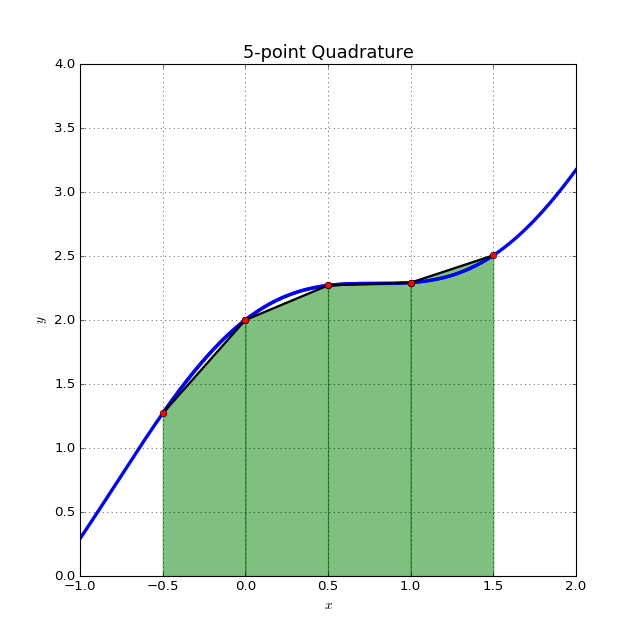

In [6]:
#Composite Quadrature method
def CompositeQuadrature( f, a, b, N, n, xmin, xmax, ymin=0, ymax=1 ):
    #X array
    X = np.linspace( a, b, N )
    
    #Plotting
    fig = plt.figure( figsize = (8,8) )
    for i in range(0,N-n,n):
        Xi = X[i:i+n+1]
        ax = Quadrature( f, Xi, X[i], X[i+n], fig=fig, leg=False )
    
    #X array
    Xarray = np.linspace( xmin, xmax, 1000 )
    #F array
    Yarray = f( Xarray )
    #Function
    ax.plot( Xarray, Yarray, linewidth = 3, color = "blue", label="$f(x)$", zorder=0 )
    ax.set_title( "%d-point Quadrature"%(N), fontsize=16 )
    #Format
    plt.xlim( (xmin, xmax) )
    plt.ylim( (ymin, ymax) )
    
    return None

#Quadrature with 3 points (Simpson's rule)
CompositeQuadrature( f, a=-0.5, b=1.5, N=5, n=1, xmin=-1, xmax=2, ymin=0, ymax=4 )

In [30]:
%%latex
\begin{align}
\int_a^b f(x)\,dx &= \int_{x_0}^{x_1} f(x) dx + \int_{x_1}^{x_2} f(x) dx + \ldots + \int_{x_{n-1}}^{x_n} f(x) dx,     \nonumber \\ 
                  &\approx h \frac{f(x_0) + f(x_1)}{2} +
		  h \frac{f(x_1) + f(x_2)}{2} + \ldots + \nonumber \\ 
		  &\quad h \frac{f(x_{n-1}) + f(x_n)}{2} 
\end{align}

<IPython.core.display.Latex object>



$$\int_a^b f(x)\,dx \approx  
\frac{h}{2}\left[f(x_0) + 2 f(x_1) + 2 f(x_2) + \ldots + 2 f(x_{n-1}) + f(x_n)\right]              
$$




$$
\int_a^b f(x)\,dx \approx h \left[\frac{1}{2}f(x_0) + \sum_{i=1}^{n-1}f(x_i) + \frac{1}{2}f(x_n) \right] \thinspace .
$$

For example, when $n = 2$


$${\frac  {b-a}{2}}(f_{0}+f_{1})$$

In [7]:
def trapezoidal(f, a, b, n):
    h = float(b-a)/n
    result = 0.5*f(a) + 0.5*f(b)
    for i in range(1, n):
        result += f(a + i*h)
    result *= h
    return result



In [8]:
a = -.5
b = 1.5
n = 1
from scipy.integrate import quad
integral, error = quad(f, a, b)
print("The integral is:", integral, "+/-", error)

The integral is: 4.245647748216942 +/- 4.713615884518398e-14


In [13]:
n = 1
integral_trapezoid = trapezoidal(f, a, b, n)

print("The trapezoid approximation with", (n+1), "points is:", integral_trapezoid)

The trapezoid approximation with 2 points is: 3.77515490463


In [14]:
n = 10
integral_trapezoid = trapezoidal(f, a, b, n)

print("The trapezoid approximation with", (n+1), "points is:", integral_trapezoid)

The trapezoid approximation with 11 points is: 4.24236367736


In [15]:
def _qnwtrap1(n, a, b):
    """
    Compute univariate trapezoid rule quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwtrap1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n < 1:
        raise ValueError("n must be at least one")

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]

    weights = dx * np.ones(n)
    weights[0] *= 0.5
    weights[-1] *= 0.5

    return nodes, weights

- The trapezoid rule is simple and robust. 

- It is said to be first order exact because, if
not for rounding error, it will exactly compute the integral of any first order polynomial,
that is, a line. 

- In general, if the integrand f is smooth, the trapezoid rule will yield an
approximation error that is $O(h^2)$, that is, the error shrinks quadratically with the width of
the subintervals.

- Doubling the nodes reduces the error by a factor of four

In [16]:
def qnwtrap(n, a, b):
    """
    Computes multivariate trapezoid rule quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwtrap`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwtrap1, n, a, b)

In [22]:
# qnwtrap and qnwsimp generate quadrature nodes and weights for trapezoid rule as follows
a = -.5
b = 1.5
n = 2 # greater than 1
x,w = qnwtrap(n,a,b)

#### Inputs 

1. n the number of nodes 

2. a the left integration limit 

3.  b the right integration limit


In [23]:
x,w

(array([-0.5,  1.5]), array([ 1.,  1.]))


#### Outputs
1.  x and w, the n× 1 vectors of quadrature nodes and weights, respectively

#### Example

For example, to compute the probability that a standard normal random variable is less than 1, execute

In [38]:
f = lambda  x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
n = 22; a = 0; b = 1 
x,w = qnwtrap(n,a,b) 
prob = 0.5 + w@f(x)

In [39]:
prob

0.84129901874106183

The computed answer, 0.8413, is correct to four significant digits

### Simpson's rule

Simpson's rule is based on piece-wise quadratic, rather than piece-wise linear, approximations
to the integrand $f$.



![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Simpsons_method_illustration.svg/440px-Simpsons_method_illustration.svg.png)

`Simpson's rule can be derived by approximating the integrand f (x) (in blue) by the quadratic interpolant P(x) (in red).`


https://en.wikipedia.org/wiki/Simpson%27s_rule




Form a piecewise quadratic approximation of by connecting successive triplets of graph points ( $\left[ \, f(x_{2j-1}) ,\, f(x_{2j}) ,\, f(x_{2j+1}) \, \right]$), with  quadratic functions

The area under this quadratic function provides an estimate of the area under f over the
subinterval:

$$\int \limits_{x_{2j-1}}^{x_{2j+1}} f(x)\, d x \approx \frac{h}{3} \left[ \, f(x_{2j-1}) + 4 \, f(x_{2j}) + f(x_{2j+1}) \, \right]$$

- where $x_i = a + (i-1)h$, 
- with $h$ (called the step size) equal to   $ h=(b − a) / (n-1)$ and n is odd. 
- The $w_i$ are called weights.


Summing up the areas under the quadratic approximants across subintervals yields Simpson's
rule:

$$\int_a^b f(x)dx \approx \sum_{i=0}^{n-1} w_if(x_i)\thinspace .$$

- where $w_1 = w_n = h/3$ 
- and, otherwise, $w_i = 4h/3$ if i is even 
- and $w_i = 2h/3$ if i is odd.

<IPython.core.display.Javascript object>


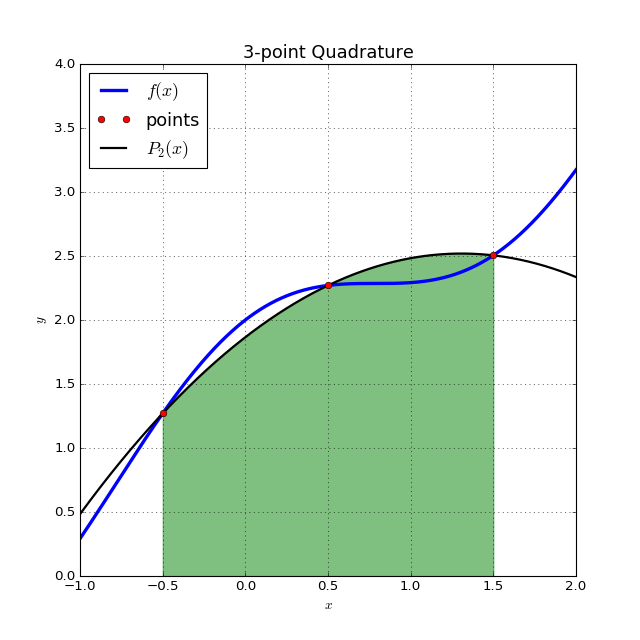

In [18]:
#Quadrature with 3 points (Simpson's rule)
X = np.array([-0.5,0.5,1.5])
Quadrature( f, X, xmin=-1, xmax=2, ymin=0, ymax=4 )

More formally, let $x_i = a + (i - 1)h$ for $i = 1; 2; ... ; n$, where
$ h=(b − a) / (n-1)$ and $n$ is odd. The nodes $x_i$ divide the interval $[a; b]$ into an even number
$n - 1$ of subintervals of equal length $h$.

## Composite Simpson's rule

Now, if we instead divide the integration interval in sets of three points, we can apply Simpson's rule to each one, obtaining:

$$ \int_a^bf(x)dx = \frac{h}{3}\left[ f(a) +2 \sum_{j=1}^{(n/2)-1}f(x_{2j})+4\sum_{j=1}^{n/2}f(x_{2j-1})+f(b) \right] - \frac{b-a}{180}h^4f^{(4)}(\mu)$$

for some value $\mu$ in $(a,b)$.

Simpson's rule is as simple as the trapezoid rule, and thus not much harder to program.
Even though Simpson's rule is based on *locally quadratic approximation* of the integrand,
it is *third order exact*. That is, it exactly computes the integral of any cubic polynomial.
In general, if the integrand is smooth, Simpson's rule yields an approximation error that is
$O(h^4)$, and thus falls at twice the geometric rate of the error associated with the trapezoid
rule.


*Simpson's rule is preferred to the trapezoid rule* when the integrand $f$ is smooth because
it retains the algorithmic simplicity of the trapezoid rule while offering **twice the degree of
approximation**. However, the trapezoid rule will often be more accurate than Simpson's rule
if the integrand exhibits **discontinuities in its first derivative**, which can occur in economic
applications exhibiting corner solutions. Newton-Cotes rules based on fourth and higher
order piecewise polynomial approximations exist, but are more difficult to work with and
thus are rarely used.

<IPython.core.display.Javascript object>


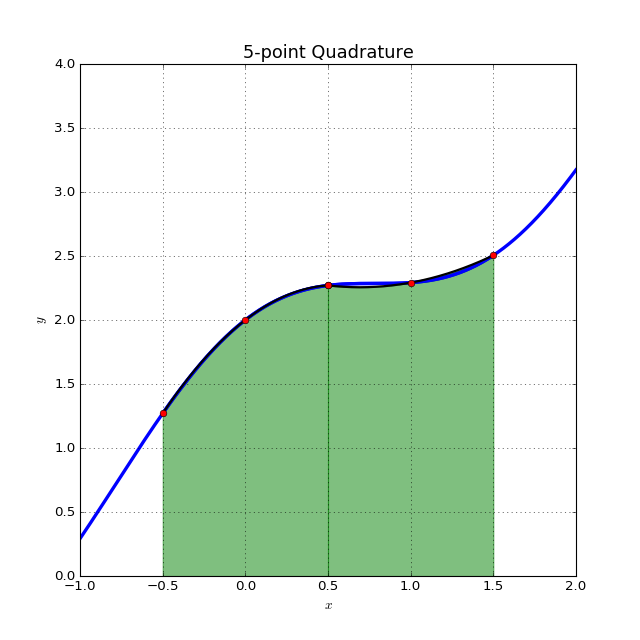

In [17]:
#Quadrature with 3 points (Simpson's rule)
CompositeQuadrature( f, a=-0.5, b=1.5, N=5, n=2, xmin=-1, xmax=2, ymin=0, ymax=4 )

### Univariate Simpson's rule

In [19]:
def _qnwsimp1(n, a, b):
    """
    Compute univariate Simpson quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwsimp1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n % 2 == 0:
        print("WARNING qnwsimp: n must be an odd integer. Increasing by 1")
        n += 1

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]
    weights = np.tile([2.0, 4.0], (n + 1) // 2)
    weights = weights[:n]
    weights[0] = weights[-1] = 1
    weights = (dx / 3.0) * weights

    return nodes, weights    

Through the use of tensor product principles, univariate Newton-Cotes quadrature schemes
can be generalized for higher dimensional integration.


This construction
principle can be applied to an arbitrary dimension using repeated tensor product operations.

In [20]:
def qnwsimp(n, a, b):
    """
    Computes multivariate Simpson quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwsimp`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwsimp1, n, a, b)

1. If is smooth, the Simpson’s rule approximation error is proportional to $h^4$

2. Doubling the nodes reduces the error by a factor of sixteen

3. Simpson’s rule is preferred to the trapezoid rule because it is almost as simple, but far more accurate

4. Newton-Cotes rules based on piecewise polynomials of third and higher degree can be defined, but are not practical

In [25]:
# qnwtrap and qnwsimp generate quadrature nodes and weights for Simpson rule as follows
a = -.5
b = 1.5
n = 3 # n must be an odd integer
x,w = qnwsimp(n,a,b)

In [26]:
x,w

(array([-0.5,  0.5,  1.5]), array([ 0.33333333,  1.33333333,  0.33333333]))

In [32]:
f = lambda  x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
n = 11; a = 0; b = 1 
x,w = qnwsimp(n,a,b) 
prob = 0.5 + w@f(x)

In [33]:
prob

0.8413450158884701

qnwsimp uses less nodes than qntrap

---

In most computational economic applications it is not possible to determine a priori
how many partition points are needed to compute an integral to a desired level of accuracy
using a Newton-Cotes quadrature rule. One solution to this problem is to use an **adaptive
quadrature strategy** whereby one increases the number of points at which the integrand is
evaluated until the sequence of estimates of the integral converge. Efficient adaptive Newton-
Cotes quadrature schemes are especially easy to implement. One simple, but powerful,
scheme calls for the number of intervals to be doubled with each iteration. Because the new
partition points include the partition points used in the previous iteration, the computational
effort required to form the new integral estimate is cut in half. More sophisticated adaptive
Newton-Cotes quadrature techniques relax the requirement that the intervals be equally
spaced and concentrate new evaluation points in those areas where the integrand appears to
be most irregular.

# Adaptive Quadrature Methods

Calculating the integrate of the function $f(x) = e^{-3x}\sin(4x)$ within the interval $[0,4]$, we obtain:

<IPython.core.display.Javascript object>


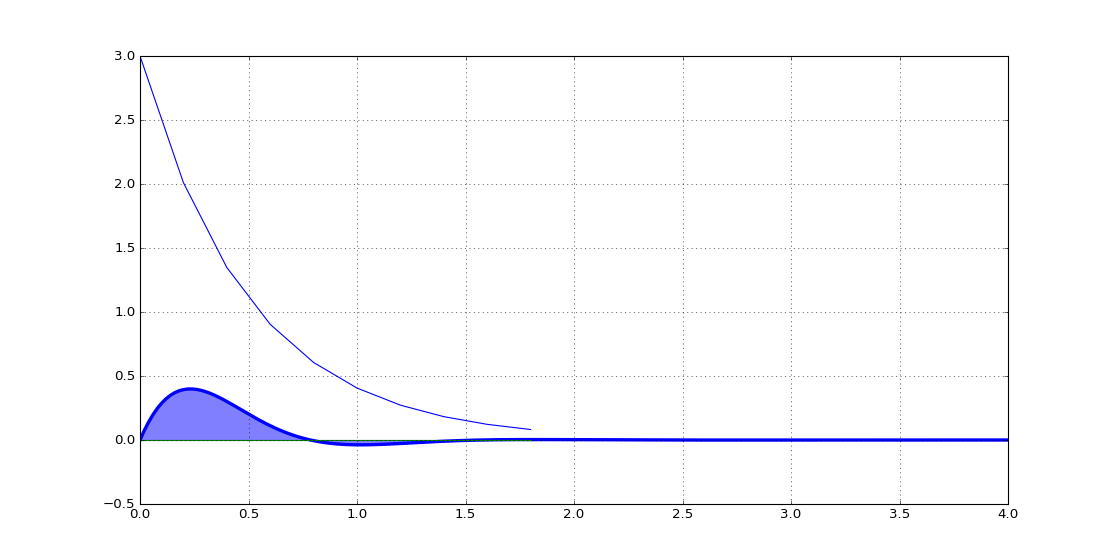

In [40]:
#Function
def f(x):
    return np.exp(-3*x)*np.sin(4*x)

#Plotting
X = np.linspace( 0, 4, 200 )
Y = f(X)
plt.figure( figsize=(14,7) )
plt.plot( X, Y, color="blue", lw=3 )
plt.fill_between( X, Y, color="blue", alpha=0.5 )
plt.xlim( 0,4 )
plt.grid()

Using composite numerical integration is not completely adequate for this problem as the function exhibits different behaviours for differente intervals. For the interval $[0,2]$ the function varies noticeably, requiring a rather small integration interval $h$. However, for the interval $[2,4]$ variations are not considerable and low-order composite integration is enough. This lays a pathological situation where simple composite methods are not efficient. In order to remedy this, we introduce an adaptive quadrature methods, where the integration step $h$ can vary according to the interval. The main advantage of this is a controlable precision of the result.

## 5.2 Gaussian Quadrature
Gaussian quadrature rules are constructed with respect to specific weighting functions.


Specifically, for a weighting function $w$ defined on an interval $I \in R$ of the real
line, and for a given order of approximation n, the quadrature nodes $x_1; x_2; ... ; x_n$
and quadrature weights $w_1; w_2; ...; w_n$ are chosen so as to satisfy the **$2n$ "moment-matching"
conditions:**




$$\int_I x^k w(x)dx = \sum_{i=1}^{n} w_i x_i^k\thinspace \forall \thinspace k = 0,...,2n-1. $$



The integral approximation is then computed by forming the prescribed weighted sum of
function values at the prescribed nodes:

$$\int_I f(x) w(x) \thinspace dx \approx \sum_{i=1}^{n} w_i f(x_i)\thinspace .$$

By construction, an n-point Gaussian quadrature rule is order $2n - 1$ exact. That is, if not
for rounding error, it will exactly compute the integral of any polynomial of order $2n - 1$ 
or less with respect to the weight function. Thus, if f can be closely approximated by a
polynomial, Gaussian quadrature should provide an accurate approximation to the integral.



![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Comparison_Gaussquad_trapezoidal.svg/880px-Comparison_Gaussquad_trapezoidal.svg.png)



*Comparison between 2-point Gaussian and trapezoidal quadrature. The blue line is the polynomial ${\displaystyle y(x)=7x^{3}-8x^{2}-3x+3}$ , whose integral in [−1, 1] is 2/3. The trapezoidal rule returns the integral of the orange dashed line, equal to ${\displaystyle y(-1)+y(1)=-10} $. The 2-point Gaussian quadrature rule returns the integral of the black dashed curve, equal to ${\displaystyle y(-{\sqrt {\scriptstyle 1/3}})+y({\sqrt {\scriptstyle 1/3}})=2/3}$. Such a result is exact, since the green region has the same area as the red regions.*

reference

https://en.wikipedia.org/wiki/Gaussian_quadrature

http://mathworld.wolfram.com/GaussianQuadrature.html

Most applications of Gaussian quadrature involve computing the expectation of a function $f$ of a continuous random variable $\tilde X$ with known probability density function $w$

## Gauss-Legendre quadrature

Gaussian quadrature over a bounded interval with respect to the identity weight function,
$w(x) \equiv 1$, is called **Gauss-Legendre quadrature**. Gauss-Legendre quadrature is special
interest because it is the Gaussian quadrature scheme appropriate for computing the area
under a curve. Gauss-Legendre quadrature is consistent for Riemann integrable functions.
That is, if f is Riemann integrable, then the approximation afforded by Gauss-Legendre
quadrature can be made arbitrarily precise by increasing the number of nodes n.




When the weight function w is the **probability density function** of some continuous random
variable $\tilde X$
, Gaussian quadrature has a very straightforward interpretation. In this
context, Gaussian quadrature essentially **"discretizes" the continuous random variable $\tilde X$**
by
replacing it with a discrete random variable with mass points $x_i$ and probabilities $w_i$ that
approximates $\tilde X$
in the sense that both random variables have the same moments of order
less than 2n:

$$ \sum_{i=1}^{n} w_i x_i^k = E \tilde X^k   \thinspace \forall \thinspace k = 0,...,2n-1. $$


Given the mass points and probabilities of the **discrete approximant**, the expectation of any
function of the **continuous random variable $\tilde X$**
may be approximated using the expectation of
the function of the discrete approximant, which requires only the computation of a weighted
sum:

$$ E f(\tilde X) = \int_I f(x) w(x) \thinspace dx \approx \sum_{i=1}^{n} w_i f(x_i)\thinspace .$$

## Probability distributions

1. Computing the n-degree Gaussian nodes and weights is a non-trivial task which involves solving the $2n$ nonlinear equations for ${x_i}$ and ${w_i}$. 

2. Effcient, specialized numerical routines for computing Gaussian quadrature nodes and weights are available for different weight functions, including virtually all the better known probability distributions such as the uniform, normal, gamma, exponential, Chi-square, and beta distributions.

3. All utilities generate mass points $x$ and probabilities $w$ as output, and require the number of mass points n as input, but differ with respect to other inputs

In [40]:
def _qnwnorm1(n):
    """
    Compute nodes and weights for quadrature of univariate standard
    normal distribution
    Parameters
    ----------
    n : int
        The number of nodes
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwnorm1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    maxit = 100
    pim4 = 1 / np.pi**(0.25)
    m = np.fix((n + 1) / 2).astype(int)
    nodes = np.zeros(n)
    weights = np.zeros(n)

    for i in range(m):
        if i == 0:
            z = np.sqrt(2*n+1) - 1.85575 * ((2 * n + 1)**(-1 / 6.1))
        elif i == 1:
            z = z - 1.14 * (n ** 0.426) / z
        elif i == 2:
            z = 1.86 * z + 0.86 * nodes[0]
        elif i == 3:
            z = 1.91 * z + 0.91 * nodes[1]
        else:
            z = 2 * z + nodes[i-2]

        its = 0

        while its < maxit:
            its += 1
            p1 = pim4
            p2 = 0
            for j in range(1, n+1):
                p3 = p2
                p2 = p1
                p1 = z * math.sqrt(2.0/j) * p2 - math.sqrt((j - 1.0) / j) * p3

            pp = math.sqrt(2 * n) * p2
            z1 = z
            z = z1 - p1/pp
            if abs(z - z1) < 1e-14:
                break

        if its == maxit:
            raise ValueError("Failed to converge in _qnwnorm1")

        nodes[n - 1 - i] = z
        nodes[i] = -z
        weights[i] = 2 / (pp*pp)
        weights[n - 1 - i] = weights[i]

    weights /= math.sqrt(math.pi)
    nodes = nodes * math.sqrt(2.0)

    return nodes, weights

def _qnwbeta1(n, a=1.0, b=1.0):
    """
    Computes nodes and weights for quadrature on the beta distribution.
    Default is a=b=1 which is just a uniform distribution

    Parameters
    ----------
    n : scalar : int
        The number of quadrature points
    a : scalar : float, optional(default=1)
        First Beta distribution parameter
    b : scalar : float, optional(default=1)
        Second Beta distribution parameter
    Returns
    -------
    nodes : np.ndarray(dtype=float, ndim=1)
        The quadrature points
    weights : np.ndarray(dtype=float, ndim=1)
        The quadrature weights that correspond to nodes
    Notes
    -----
    Based of original function ``_qnwbeta1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    # We subtract one and write a + 1 where we actually want a, and a
    # where we want a - 1
    a = a - 1
    b = b - 1

    maxiter = 25

    # Allocate empty space
    nodes = np.zeros(n)
    weights = np.zeros(n)

    # Find "reasonable" starting values.  Why these numbers?
    for i in range(n):
        if i == 0:
            an = a/n
            bn = b/n
            r1 = (1+a) * (2.78/(4+n*n) + .768*an/n)
            r2 = 1 + 1.48*an + .96*bn + .452*an*an + .83*an*bn
            z = 1 - r1/r2
        elif i == 1:
            r1 = (4.1+a) / ((1+a)*(1+0.156*a))
            r2 = 1 + 0.06 * (n-8) * (1+0.12*a)/n
            r3 = 1 + 0.012*b * (1+0.25*abs(a))/n
            z = z - (1-z) * r1 * r2 * r3
        elif i == 2:
            r1 = (1.67+0.28*a)/(1+0.37*a)
            r2 = 1+0.22*(n-8)/n
            r3 = 1+8*b/((6.28+b)*n*n)
            z = z-(nodes[0]-z)*r1*r2*r3
        elif i == n - 2:
            r1 = (1+0.235*b)/(0.766+0.119*b)
            r2 = 1/(1+0.639*(n-4)/(1+0.71*(n-4)))
            r3 = 1/(1+20*a/((7.5+a)*n*n))
            z = z+(z-nodes[-4])*r1*r2*r3
        elif i == n - 1:
            r1 = (1+0.37*b) / (1.67+0.28*b)
            r2 = 1 / (1+0.22*(n-8)/n)
            r3 = 1 / (1+8*a/((6.28+a)*n*n))
            z = z+(z-nodes[-3])*r1*r2*r3
        else:
            z = 3*nodes[i-1] - 3*nodes[i-2] + nodes[i-3]

        ab = a+b

        # Root finding
        its = 0
        z1 = -100
        while abs(z - z1) > 1e-10 and its < maxiter:
            temp = 2 + ab
            p1 = (a-b + temp*z)/2
            p2 = 1

            for j in range(2, n+1):
                p3 = p2
                p2 = p1
                temp = 2*j + ab
                aa = 2*j * (j+ab)*(temp-2)
                bb = (temp-1) * (a*a - b*b + temp*(temp-2) * z)
                c = 2 * (j - 1 + a) * (j - 1 + b) * temp
                p1 = (bb*p2 - c*p3)/aa

            pp = (n*(a-b-temp*z) * p1 + 2*(n+a)*(n+b)*p2)/(temp*(1 - z*z))
            z1 = z
            z = z1 - p1/pp

            if abs(z - z1) < 1e-12:
                break

            its += 1

        if its == maxiter:
            raise ValueError("Max Iteration reached.  Failed to converge")

        nodes[i] = z
        weights[i] = temp/(pp*p2)

    nodes = (1-nodes)/2
    weights = weights * math.exp(gammaln(a+n) + gammaln(b+n)
                                 - gammaln(n+1) - gammaln(n+ab+1))
    weights = weights / (2*math.exp(gammaln(a+1) + gammaln(b+1)
                         - gammaln(ab+2)))

    return nodes, weights


def _qnwgamma1(n, a=None):
    """
    Insert docs.  Default is a=0
    NOTE: For now I am just following compecon; would be much better to
    find a different way since I don't know what they are doing.
    Parameters
    ----------
    n : scalar : int
        The number of quadrature points
    a : scalar : float
        Gamma distribution parameter
    Returns
    -------
    nodes : np.ndarray(dtype=float, ndim=1)
        The quadrature points
    weights : np.ndarray(dtype=float, ndim=1)
        The quadrature weights that correspond to nodes
    Notes
    -----
    Based of original function ``qnwgamma1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if a is None:
        a = 0
    else:
        a -= 1

    maxit = 10

    factor = -math.exp(gammaln(a+n) - gammaln(n) - gammaln(a+1))
    nodes = np.zeros(n)
    weights = np.zeros(n)

    # Create nodes
    for i in range(n):
        # Reasonable starting values
        if i == 0:
            z = (1+a) * (3+0.92*a) / (1 + 2.4*n + 1.8*a)
        elif i == 1:
            z = z + (15 + 6.25*a) / (1 + 0.9*a + 2.5*n)
        else:
            j = i-1
            z = z + ((1 + 2.55*j) / (1.9*j) + 1.26*j*a / (1 + 3.5*j)) * \
                (z - nodes[j-1]) / (1 + 0.3*a)

        # root finding iterations
        its = 0
        z1 = -10000
        while abs(z - z1) > 1e-10 and its < maxit:
            p1 = 1.0
            p2 = 0.0
            for j in range(1, n+1):
                p3 = p2
                p2 = p1
                p1 = ((2*j - 1 + a - z)*p2 - (j - 1 + a)*p3) / j

            pp = (n*p1 - (n+a)*p2) / z
            z1 = z
            z = z1 - p1/pp
            its += 1

        if its == maxit:
            raise ValueError('Failure to converge')

        nodes[i] = z
        weights[i] = factor / (pp*n*p2)

    return nodes, weights

In [41]:
def qnwnorm(n, mu=None, sig2=None, usesqrtm=False):
    """
    Computes nodes and weights for multivariate normal distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwnorm`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    n = np.asarray(n)
    d = n.size

    if mu is None:
        mu = np.zeros(d)
    else:
        mu = np.asarray(mu)

    if sig2 is None:
        sig2 = np.eye(d)
    else:
        sig2 = np.asarray(sig2).reshape(d, d)

    if all([x.size == 1 for x in [n, mu, sig2]]):
        nodes, weights = _qnwnorm1(n)
    else:
        nodes = []
        weights = []

        for i in range(d):
            _1d = _qnwnorm1(n[i])
            nodes.append(_1d[0])
            weights.append(_1d[1])

        nodes = gridmake(*nodes)
        weights = ckron(*weights[::-1])

    if usesqrtm:
        new_sig2 = la.sqrtm(sig2)
    else:  # cholesky
        new_sig2 = la.cholesky(sig2)

    if d > 1:
        nodes = nodes.dot(new_sig2) + mu  # Broadcast ok
    else:  # nodes.dot(sig) will not be aligned in scalar case.
        nodes = nodes * new_sig2 + mu

    return nodes.squeeze(), weights


def qnwlogn(n, mu=None, sig2=None):
    """
    Computes nodes and weights for multivariate lognormal distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwlogn`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    nodes, weights = qnwnorm(n, mu, sig2)
    return np.exp(nodes), weights




def qnwunif(n, a, b):
    """
    Computes quadrature nodes and weights for multivariate uniform
    distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwunif`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    n, a, b = list(map(np.asarray, [n, a, b]))
    nodes, weights = qnwlege(n, a, b)
    weights = weights / np.prod(b - a)
    return nodes, weights




def quadrect(f, n, a, b, kind='lege', *args, **kwargs):
    """
    Integrate the d-dimensional function f on a rectangle with lower and
    upper bound for dimension i defined by a[i] and b[i], respectively;
    using n[i] points.
    Parameters
    ----------
    f : function
        The function to integrate over. This should be a function
        that accepts as its first argument a matrix representing points
        along each dimension (each dimension is a column). Other
        arguments that need to be passed to the function are caught by
        `*args` and `**kwargs`
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    kind : string, optional(default='lege')
        Specifies which type of integration to perform. Valid
        values are:
        lege - Gauss-Legendre
        cheb - Gauss-Chebyshev
        trap - trapezoid rule
        simp - Simpson rule
        N    - Neiderreiter equidistributed sequence
        W    - Weyl equidistributed sequence
        H    - Haber  equidistributed sequence
        R    - Monte Carlo
    *args, **kwargs :
        Other arguments passed to the function f
    Returns
    -------
    out : scalar (float)
        The value of the integral on the region [a, b]
    Notes
    -----
    Based of original function ``quadrect`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if kind.lower() == "lege":
        nodes, weights = qnwlege(n, a, b)
    elif kind.lower() == "cheb":
        nodes, weights = qnwcheb(n, a, b)
    elif kind.lower() == "trap":
        nodes, weights = qnwtrap(n, a, b)
    elif kind.lower() == "simp":
        nodes, weights = qnwsimp(n, a, b)
    else:
        nodes, weights = qnwequi(n, a, b, kind)

    out = weights.dot(f(nodes, *args, **kwargs))
    return out


def qnwbeta(n, a=1.0, b=1.0):
    """
    Computes nodes and weights for beta distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float), optional(default=1.0)
        A length-d
    b : array_like(float), optional(default=1.0)
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwbeta`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwbeta1, n, a, b)


def qnwgamma(n, a=None):
    """
    Computes nodes and weights for gamma distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwgamma`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwgamma1, n, a)

-  For normal distribution

x,w = qnwnorm(n,mu,var)
where, mu is the mean and var is the variance

-  For lognormal distribution

x,w = qnwlogn(n,mu,var)

where, mu is the log mean and var is the log variance

-  For Beta distribution

x,w = qnwbeta(n,a,b)

where, a and b are the shape parameters 

-  For Gamma distribution

x,w = qnwgamma(n,a,b) 

where, a is the shape parameter and b is the scale parameter



In [42]:
def qnwlogn(n, mu=None, sig2=None):
    """
    Computes nodes and weights for multivariate lognormal distribution
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    mu : scalar or array_like(float), optional(default=zeros(d))
        The means of each dimension of the random variable. If a scalar
        is given, that constant is repeated d times, where d is the
        number of dimensions
    sig2 : array_like(float), optional(default=eye(d))
        A d x d array representing the variance-covariance matrix of the
        multivariate normal distribution.
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwlogn`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    nodes, weights = qnwnorm(n, mu, sig2)
    return np.exp(nodes), weights

#### To compute the agent’s expected utility with random income, execute

##### A Risk Problem
1. An agent’s utility of income exhibits constant absolute risk aversion $\alpha$ , viz.

$$u(y) = -exp(- \alpha  y)$$

2. The agent faces uncertain income $\tilde y$ that is log-normally distributed with parameters $\mu$ and $\sigma^2$

3. Would this agent accept a certain income $y^∗$ in place of his uncertain income $\tilde y$?

4. According to expected utility theory, yes, provided 

$$u(y^∗) \ge Eu(\tilde y)$$

In [42]:
n = 100
mu = 0
var = 0.1
alpha = 2
ystar = 1
y,w = qnwlogn(n,mu,var)
expectedutility = -w@np.exp(-alpha*y)
ucert = -np.exp(-alpha*ystar)

In [44]:
expectedutility

-0.14792769600793104

In [43]:
ucert

-0.1353352832366127

This generates the approximation $Eu(\tilde y) = -0.148$
which is less than $u(y^*) = -0.135$


Yes, the agent would accept the certain income

The utility `qnwnorm` also generates discrete approximations for multivariate normal variates

To generate mass points and probabilities for d jointly distributed normal random variables, execute the script

`x,w = qnwnorm(n,mu,var)`


where n is a 1×d vector indicating the number of mass points for each variable, mu is the 1×d mean vector, and var is the d× d covariance matrix

On output, x is an N× d vector of mass points and w is an N× 1 vector of probabilities, where N= n 1⋅ n 2⋅… ⋅ n(d)

##### Example

A farmer’s per-acre revenue is the product of the unit price $\tilde p$ and peracre yield $\tilde y$, the logs of which are jointly normally distributed with the mean vector and covariance matrix


In [46]:
mu = np.array([1, 2])
mu

array([1, 2])

In [48]:
omega = np.array([[0.2, -0.1], [-0.1, 0.4]])
omega

array([[ 0.2, -0.1],
       [-0.1,  0.4]])

To compute the farmer’s expected revenue using a grid of 150 mass points formed as the Cartesian product of 10 price nodes and 15 yield nodes, execute

In [52]:
x,w = qnwnorm([10, 15],mu,omega)

p = np.exp(x[:,0])

y = np.exp(x[:,1])

expectedrevenue = w@(p*y)

expectedrevenue

24.532530197109299

As was the case with Newton-Cotes quadrature, tensor product principles may be used
to generalize Gaussian quadrature rules to higher-dimensional integration.

reference: 

http://compeconworkshop.org/PDF/Part04.pdf

https://people.ucsc.edu/~ealdrich/Teaching/ComputationGroup/Slides/lec3.pdf

http://www.econ.nyu.edu/user/violante/NYUTeaching/QM/Spring15/Lectures/Lecture6_Integration_Slides.pdf

https://github.com/birocoles/Disciplina-metodos-computacionais/blob/master/Content/newton-cotes.ipynb

http://nbviewer.jupyter.org/github/sbustamante/ComputationalMethods/blob/master/material/numerical-calculus.ipynb#Numerical-Integration

---

## 5.3 Monte Carlo Integration

In numerical integration, methods such as the trapezoidal rule use a deterministic approach. Monte Carlo integration, on the other hand, employs a non-deterministic approach: each realization provides a different outcome.


![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/MonteCarloIntegrationCircle.svg/440px-MonteCarloIntegrationCircle.svg.png)




Monte Carlo integration methods are motivated by the **Strong Law of Large Numbers.**

One version of the Law states that if $x_1; x_2; ... ; x_n$ are independent realizations of a random variable $\tilde X$ and $f$ is a continuous function, then


$$\lim _{{n\to \infty }} \frac{1}{n} \sum_{i=1}^{n}  f(x_i) =  E f(\tilde X)$$

with probability one.

The Monte Carlo integration scheme is thus a simple one. To compute an approximation to the expectation of $f(\tilde X)$, one draws a random sample $x_1; x_2; ... ; x_n$ from the distribution of $\tilde X$ and sets



$$  E f(\tilde X) \approx \frac{1}{n} \sum_{i=1}^{n}  f(x_i) $$


Monte Carlo integration uses uniform weights and “randomly” generated nodes

**But could we draw a truly random sample?**

### Random Number Generators

Most numerical software packages provide a routine that generates pseudo-random variables
that are uniformly distributed on the interval [0; 1]. A uniform random number generator
is useful for generating random samples from other distributions. Suppose $\tilde X$ has a cumulative distribution function  

$$ F(x) = Pr( \tilde X \le x) $$


whose inverse has a well-defined closed form. If $\tilde U$ is uniformly distributed on $(0; 1)$, then
$F^{-1}( \tilde U)$ has the same distribution as $\tilde X$.

Most numerical software packages also provide an intrinsic routine that generates pseudorandom
standard normal variables. The routine may also be used to generate pseudo-random sequences of lognormal and multivariate normal variables.



A fundamental problem that arises with Monte Carlo integration is that it is almost impossible
to generate a truly random sample of variates for any distribution. Most compilers
and vector processing packages provide intrinsic routines for computing so-called random
numbers. These routines, however, employ iteration rules that generate a purely deterministic,
not random, sequence of numbers. In particular, if the generator is repeatedly initiated
at the same point, it will return the same sequence of "random" variates each time. About
all that can be said of numerical random number generators is that good ones will generate
sequences that appear to be random, in that they pass certain statistical tests for randomness.
For this reason, numerical random number generators are more accurately said to
generate sequences of *"pseudo-random"* rather than random numbers.

- Python numpy offers two intrinsic random number generators 

- np.random.rand(m,n) generates an matrix of numbers that are independently uniformly distributed on the interval


- np.random.randn(m,n) generates an matrix of numbers that are independently standard normally distributed

In [54]:
np.random.seed(123)

In [55]:
np.random.rand(4,3)

array([[ 0.69646919,  0.28613933,  0.22685145],
       [ 0.55131477,  0.71946897,  0.42310646],
       [ 0.9807642 ,  0.68482974,  0.4809319 ],
       [ 0.39211752,  0.34317802,  0.72904971]])

In [56]:
np.random.randn(4,3)

array([[-0.67888615, -0.09470897,  1.49138963],
       [-0.638902  , -0.44398196, -0.43435128],
       [ 2.20593008,  2.18678609,  1.0040539 ],
       [ 0.3861864 ,  0.73736858,  1.49073203]])

Monte Carlo integration is easy to implement andmay be preferred over Gaussian quadrature
if the a routine for computing the Gaussian mass points and probabilities is not readily
available or if the integration is over many dimensions. Monte Carlo integration, however, is
subject to a sampling error that cannot be bounded with certainty. The approximation can
be made more accurate, in a dubious statistical sense, by increasing the size of the random
sample, but this can be expensive if evaluating f or generating the pseudo-random variate is
costly. Approximations generated by Monte Carlo integration will vary from one integration
to the next, unless initiated at the same point, making the use of Monte Carlo integration
in conjunction within other iterative schemes, such as dynamic programming or maximum
likelihood estimation, problematic. So-called quasi Monte-Carlo methods can circumvent
some of the problems associated with Monte-Carlo integration.

Quasi-Monte Carlo uses a low-discrepancy sequence such as the Halton sequence, the Sobol sequence, or the Faure sequence, whereas Monte Carlo uses a pseudorandom sequence. The advantage of using low-discrepancy sequences is a faster rate of convergence. Quasi-Monte Carlo has a rate of convergence close to $O(1/N)$, whereas the rate for the Monte Carlo method is $O(N^{−0.5})$.






The Quasi-Monte Carlo method recently became popular in the area of mathematical finance or computational finance. In these areas, high-dimensional numerical integrals, where the integral should be evaluated within a threshold ε, occur frequently. Hence, the Monte Carlo method and the quasi-Monte Carlo method are beneficial in these situations.

https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

## 5.4 Quasi-Monte Carlo Integration


Although Monte-Carlo integration methods originated using insights from probability
theory, recent extensions have severed that connection and, in the process, demonstrated
ways in which the methods can be improved. Monte-Carlo methods rely on
sequences $x_i$ with the property that


$$\lim _{{n\to \infty }} \frac{b-a}{n} \sum_{i=1}^{n}  f(x_i) =  \int_{a}^{b} f(x) dx$$


without regard to whether the sequences passes standard tests of randomness. Any sequence
that satisfies this condition for arbitrary (Riemann) integrable functions can be used to approximate an integral on [a; b]. Although the Law of Large Numbers assures us that this is true when the $x_i$ are independent and identically distributed random variables, other
sequences also satisfy this property. Indeed, it can be shown that sequences that are explicitly
non-random, but instead attempt to fill in space in a regular manner can often provide more
accurate approximations to definite integrals.


There are numerous schemes for generating equidistributed sequences, including **the Neiderreiter,
Weyl, and Haber sequences.**

All of the quadrature functions will use tensor products to generate nodes and
weights for integration over an arbitrary bounded interval [a; b] in higher dimensional
spaces.

## 5.5 An Integration Toolbox
The Matlab toolbox accompanying the textbook includes four functions for computing
numerical integrals for general functions. Each takes three inputs, n, a, and b and
generates appropriate nodes and weights. The functions `qnwtrap` and `qnwsimp` implement the Newton-Cotes trapezoid and Simpson's rule methods, `qnwlege` implements
Gauss-Legendre quadrature and `qnwequi` generates nodes and weights associated with
either equidistributed or pseudo-random sequences. The calling syntax is the same
for each and is illustrated with below with `qnwtrap`.




In [57]:
def qnwlege(n, a, b):
    """
    Computes multivariate Guass-Legendre  quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwlege`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwlege1, n, a, b)

In [58]:
def qnwequi(n, a, b, kind="N", equidist_pp=None):
    """
    Generates equidistributed sequences with property that averages
    value of integrable function evaluated over the sequence converges
    to the integral as n goes to infinity.
    Parameters
    ----------
    n : int
        Number of sequence points
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    kind : string, optional(default="N")
        One of the following:
        - N - Neiderreiter (default)
        - W - Weyl
        - H - Haber
        - R - pseudo Random
    equidist_pp : array_like, optional(default=None)
        TODO: I don't know what this does
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwequi`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if equidist_pp is None:
        equidist_pp = np.sqrt(np.array(list(sym.primerange(0, 7920))))

    n, a, b = list(map(np.atleast_1d, list(map(np.asarray, [n, a, b]))))

    d = max(list(map(len, [n, a, b])))
    n = np.prod(n)

    if a.size == 1:
        a = np.repeat(a, d)

    if b.size == 1:
        b = np.repeat(b, d)

    i = np.arange(1, n + 1)

    if kind.upper() == "N":  # Neiderreiter
        j = 2.0 ** (np.arange(1, d+1) / (d+1))
        nodes = np.outer(i, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "W":  # Weyl
        j = equidist_pp[:d]
        nodes = np.outer(i, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "H":  # Haber
        j = equidist_pp[:d]
        nodes = np.outer(i * (i+1) / 2, j)
        nodes = (nodes - np.fix(nodes)).squeeze()
    elif kind.upper() == "R":  # pseudo-random
        nodes = np.random.rand(n, d).squeeze()
    else:
        raise ValueError("Unknown sequence requested")

    # compute nodes and weights
    r = b - a
    nodes = a + nodes * r
    weights = (np.prod(r) / n) * np.ones(n)

    return nodes, weights

For example, to compute the definite integral of $exp(x)$ on $[-1; 2]$ using a 10 point
**trapezoid rule** one would write:

In [84]:
x,w = qnwtrap(10,-1,2)
print(x.shape, w.shape)
integral = w.T@np.exp(x)
integral

(10,) (10,)


7.0860674798034795

To compute the definite integral using a 100 point **Neiderrieter rule** one would instead generate
the nodes and weights as follows:

In [85]:
[x,w] = qnwequi(100,-1,2,'N')
print(x.shape, w.shape)
integral = w.T@np.exp(x)
integral

(100,) (100,)


6.9594934034194891

Each of the aforementioned routines also may be used to compute definite integrals of
real-valued multivariate functions over bounded intervals in higher dimensional spaces. The
routines generate nodes and weights for higher dimensional quadrature by forming the tensor
products of univariate nodes and weights. For example, suppose one wished to compute the
integral of $exp(x_1 + x_2)$ over the rectangle $[1, 2] \times [0, 5]$ in $R^2$. One could call `qnwtrap` to
construct a grid of, say, 300 quadrature nodes produced by taking the cross-product of 10
nodes in the $x_1$ direction and 20 nodes in the $x_2$ direction:

In [86]:
[x,w] = qnwtrap([10, 20],[1, 0],[2, 5])
print(x.shape, w.shape)
integral = w.T@np.exp(x[:,0]+x[:,1])
integral

(200, 2) (200,)


693.21484838570734

A similar calling syntax is used for qnwsimp, and qnwlege.

The calling syntax for qnwequi when performing multidimensional integration requires
n to be an integer indicating the the total number of integration nodes. Thus, to compute
the definite integral using a 10000 point **Neiderrieter rule** one would generate the nodes and
weights as follows:

In [87]:
[x,w] = qnwequi(10000,[1, 0],[2, 5],'N');
print(x.shape, w.shape)
integral = w.T@np.exp(x[:,0]+x[:,1]);
integral

(10000, 2) (10000,)


688.11063978493848

In addition to the general integration routines, there are
several functions for computing Gaussian nodes and weights associated with common probability
distribution functions. The routine qnwnorm generates the Gaussian quadrature nodes
and weights for normal random variables. For univariate normal distributions, the calling
syntax takes the form

`[x,w] = qnwnorm(n,mu,var)`

where x are the nodes, w are the probability weights, n is the number nodes and weights,
mu the mean of the distribution, and var is the variance of the distribution. If mu and var
are omitted, the mean and variance are assumed to be 0 and 1, respectively. For example,
suppose one wanted to compute the expectation of $exp( \tilde X)$ where $\tilde X$
is normally distributed
with mean 2 and variance 4. An approximate expectation could be computed using the
following code:

In [88]:
[x,w] = qnwnorm(3,2,4)
print(x.shape,w.shape)
expectation = w.T@np.exp(x)
expectation

(3,) (3,)


44.308532309131976

The routine qnwnorm also generates nodes and weights for multivariate normal random
variables. For example, suppose one wished to compute the expectation of $exp( \tilde X_1 + \tilde X_2 )$
where $\tilde X$ and $\tilde X$ are jointly normal with  $E \tilde X_1  = 3 $, $E \tilde X_2 = 4$, $V \tilde X_1 = 2$, $V \tilde X_2 = 4$, and $Cov( \tilde X_1,\tilde X_2) = -1 $.

One could then invoke `qnwnorm` to construct a grid of 150 Gaussian quadrature nodes as the cross-product of 10 nodes in the $x_1$ direction and 15 nodes in the $x_2$ direction, and then form the weighted sum of the assigned weights and function values at the nodes:




In [89]:
[x,w] = qnwnorm([10, 15],[3, 4],[[2, -1], [-1, 4]])
print(x.shape,w.shape)
expectation = w.T@np.exp( x[:,0]+x[:,1] )
expectation

(150, 2) (150,)


8103.0839275730086

## 5.6 Numerical Differentiation

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Derivative.svg/460px-Derivative.svg.png)


The most natural way to approximate a derivative is to replace it with a finite difference.
The definition of a derivative,

$$ f'(x)=\lim _{{h\to 0}}{f(x+h)-f(x) \over h}. $$

suggests a natural way to do this. One can simply take h to be a small number, knowing
that, for h small enough, the error of the approximation will also be small. We will return
to the question of how small h should be, but first we address the issue of how large an error
is produced using this finite difference approach.


An error bound for the approximation can be be obtained using a Taylor expansion. We
know, for example, that
$$f(x + h) = f(x) + f'(x)h + O(h^2);$$

where $O(h^2)$ means that other terms in the expression are expressible in terms of second or
higher powers of h. If we rearrange this expression we see that

$$f'(x) = [f(x + h) - f(x)]/h + O(h)$$

(since $O(h^2)/h = O(h)$), so the approximation to the derivative $f'(x)$ has an $O(h)$ error.

### A more accurate finite difference approximation



Another two-point formula is to compute the slope of a nearby secant line through the points $(x-h,f(x-h))$ and $(x+h,f(x+h))$. The slope of this line is
$$f'(x) =    {\displaystyle {f(x+h)-f(x-h) \over 2h } + O(h^2) .} $$
This formula is known as the symmetric difference quotient. In this case the first-order errors cancel, so the slope of these secant lines differ from the slope of the tangent line by an amount that is approximately proportional to ${\displaystyle h^{2}}$. Hence for small values of h this is a more accurate approximation to the tangent line than the one-sided estimation. 

This is called the **centered finite difference approximation** to the derivative of $f$ at $x$. Its
error is $O(h^2)$, or one order more accurate than the one-sided finite difference approximation
above.



Other 3-point approximations are also possible.

### A special case the approximation in the centered finite difference approximation

a formula that is useful when a derivative is needed at a boundary of a domain. In this case

$$f'(x) = {1 \over 2h} [-3f(x) + 4f(x + h) - f(x + 2h)] + O(h^2)$$
(use h > 0 for a lower bound and h < 0 for an upper bound).






### **Finite difference approximations** for higher order derivatives 

can be found using a similar
approach. For, example an order $O(h^2)$ centered finite difference approximation to the second
derivative may be constructed using the two third-order Taylor expansions

$$f''(x) = {f(x + h) - 2f(x) + f(x - h) \over h^2} + O(h^2)$$

To obtain general formulii for second derivatives with second order accuracy,

a formula that is useful when a derivative is needed at a boundary of the
domain. In this case


$$f''(x) ={1 \over h^2} [2f(x) - 5f(x + h) + 4f(x + 2h) - f(x + 3h)] + O(h^2)$$



### computing Hessian matrices


An important use of second derivatives is in computing Hessian matrices. Given some
function $f : R^n \rightarrow R$, the Hessian is the $n \times n$ matrix of second partial derivatives, the $ij$th element of which is ${ \partial^2 f(x)\over  \partial x_i \partial x_j}$
. We consider only centered, evenly spaced approximations, which
can be obtained as a weighted sum of the function values evaluated at the point x and 8
points surrounding it obtained by adding or subtracting $h_i u_i$ and/or $h_j u_j$, where the h terms
are scalar step increments and the u terms are n-vectors of zeros but with the ith element
equal to 1 (the $i$th column of $I_n$).

and let superscripts on f denote the function evaluated at one
of the 9 points of interest, so $f^{++} = f(x + h_i u_i + h_j u_j)$, $f^{00} = f(x), f^{0-} = f(x - h_j u_j)$, etc.


The obvious combination of taking the mean of the two results in

$$f_{ij} \approx {1 \over 4h_i h_j} (f^{++} + f^{--} - f^{-+} -  f^{+-})$$

This requires less computation than the other two forms if only a single cross partial is
evaluated. Using either of the other two schemes, however, along with the usual centered
approximation for the diagonal terms of the Hessian enables one to compute the entire
Hessian with second order accuracy in $1 + n + n^2$ function evaluations.


### the errors in approximating
When a function can be evaluated at any point, the choice of evaluation points must be
considered. As with convergence criteria, there is no one rule that always works. If **$h$ is
made too small, round-off error can make the results meaningless**. On the other hand, too
large an h provides a poor approximation, even if exact arithmetic is used.

This gives credence to the rule of
thumb that, for one-sided approximations, h should be chosen to be of size $\epsilon$ relative to
x. When x is small, however, it is better not to let h get too small. We suggest the rule of
thumb of setting 

$$h = max(x, 1) \sqrt{ \epsilon} $$


It is evident that the
error is minimized at a much higher value of h, at approximately $\sqrt[3]{\epsilon}$. A good rule of thumb
is to set

$$h = max(x, 1) \sqrt[3]{ \epsilon} $$


We provide below a function that computes two-sided finite difference approximations for
the Jacobian of an arbitrary function. For a real-valued function, $f :R^n \rightarrow R$, the output
is an $m \times n$ matrix:






In [11]:
def fdjac(func, x, *args, **kwargs):

    # if type(func(x, *args, **kwargs)) is tuple:
    #     F = lambda x: func(x, *args, **kwargs)[0]
    # else:
    #     F = lambda x: func(x, *args, **kwargs)
    F = lambda z: func(z, *args, **kwargs)

    x = x.flatten()
    dx = x.size
    f = F(x)
    df = f.size
    x = x.astype(float)

    ''' Compute Jacobian'''
    eps = np.spacing(1) 

    h = eps** (1/3) * np.maximum(abs(x), 1)
    xh0 = x - h
    xh1 = x + h
    h = xh1 - xh0
    fjac = np.zeros((dx, df))

    for j in range(dx):
        xx = x.copy()
        xx[j] = xh1[j]
        f1 = F(xx)

        xx[j] = xh0[j]
        f0 = F(xx)

        fjac[j] = np.squeeze((f1 - f0) / h[j])  # fixme doing this to deal with broadcasting

    return fjac.T

In [12]:
# example

def cournot(q):
    c = np.array([0.6, 0.8])
    eta = 1.6
    e = -1 / eta
    fval = np.sum(q)**e + e * np.sum(q)**(e-1)*(q) - np.diag(c).dot(q)
    return fval

f = cournot
x = np.array([0.2, 0.2])
# using numerical finite difference function to calculate Jacobian
fjac = fdjac(cournot,np.array([0.2, 0.2]) )
fjac

array([[-3.88977465, -0.5194381 ],
       [-0.5194381 , -4.08977465]])

## 5.7 Initial Value Problems
Differential equations pose the problem of inferring a function given information
about its derivatives and additional "boundary" conditions. Differential equations
may characterized as either **ordinary differential equations (ODEs)**, whose solutions
are functions of a single argument, and **partial differential equations (PDEs)**, whose
solutions are functions of multiple arguments. Both ODEs and PDEs may be solved
numerically using finite difference methods.

From a numerical point of view the distinction between ODEs and PDEs is less
important than the distinction between **initial value problems (IVPs)**, which can be
solved in a recursive or evolutionary fashion, and **boundary value problems (BVPs)**,
which require the entire solution to be computed simultaneously because the solution
at one point (in time and/or space) depends on the solution everywhere else. For
ODEs, the solution of an IVP is known at some point and the solution near this
point can then be (approximately) determined. This, in turn, allows the solution at
still other points to be approximated and so forth. BVPs, on the other hand, require
simultaneous solution of the differential equation and the boundary conditions. We
take up the solution of IVPs in this section, but defer discussion of BVPs until the
next chapter (page 164).

The most common initial value problem is to find a function $x : [0, T] \rightarrow R^2$ whose initial
value $x(0)$ is known and which, over its domain, satisfies the differential equation

$$x'(t) = f(t,x(t)).$$


Here, $x$ is a function of a scalar $t$ (often referring to time in economic applications) and
$f : [0, T] \times R^2 \rightarrow R^2$ is a given function.

Initial value problems can be solved using a recursive procedure. First the direction of
motion is calculated based on the current position of the system and a small step is taken
in that direction. This is then repeated as many times as is desired. The inputs needed for these methods are the functions defining the system $f$, an initial value $x_0$, the time step size
h, and the number of steps to take n (or, equivalently, the stopping point T).

### Euler's method

The most simple form of such a procedure is **Euler's method**. The ith iteration of the
procedure generates an approximation for the value of the solution function $x$ at time $t_i$


$$x_{i+1} = x_i + hf(t_i, x_i),$$

with the procedure beginning at the prescribed $x_0 = x(0)$. This method is fine for rough
approximations, especially if the time step is small enough. Higher order approximations
can yield better results, however.

<IPython.core.display.Javascript object>


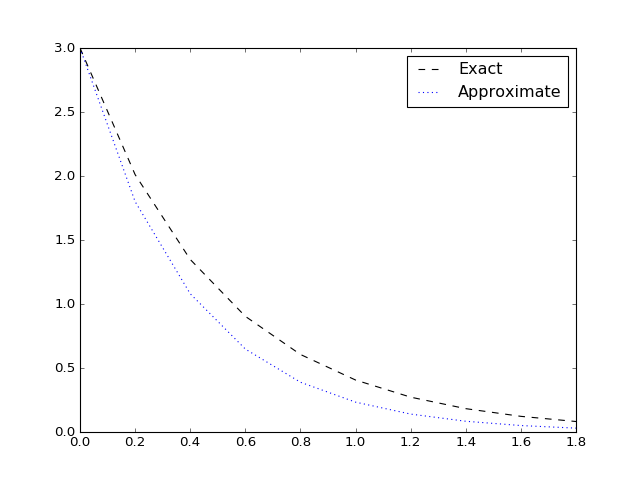

In [104]:
## Example 1
# Solve y'(t)=-2y(t) with y0=3
y0 = 3;                  # Initial Condition
h = 0.2;# Time step
t = np.arange(0,2 ,h)                # t goes from 0 to 2 seconds.
yexact = 3*np.exp(-2*t)     # Exact solution (in general we won't know this)
ystar = np.zeros(len(t))  # Preallocate array (good coding practice)

ystar[0] = y0           # Initial condition gives solution at t=0.
for i in range(len(t)-1):
    k1 = -2*ystar[i];  # Previous approx for y gives approx for derivative
    ystar[i+1] = ystar[i] + k1*h # Approximate solution for next value of y

fig, ax = plt.subplots()
ax.plot(t,yexact,'k--', label = 'Exact' )
ax.plot(t,ystar,':',label = 'Approximate' )

plt.legend()

### Runge-Kutta method

Among the numerous refinements on the Euler method, the most commonly used are the
Runge-Kutta methods. Runge-Kutta methods are a class of methods characterized by an
order of approximation and by selection of certain key parameters. The derivation of these
methods is fairly tedious for high order methods but are easily demonstrated for a second
order model.

Reference:
https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

the following second order Runge-Kutta methods:

Let an initial value problem be specified as follows:
$${\displaystyle {\dot {y}}=f(t,y),\quad y(t_{0})=y_{0}.}$$

$$y_{n+1}=y_{n}+h{\bigl (}(1-{\tfrac {1}{2\alpha }})f(t_{n},y_{n})+{\tfrac {1}{2\alpha }}f(t_{n}+\alpha h,y_{n}+\alpha hf(t_{n},y_{n})){\bigr )} + O(h^3).$$

It can be shown that an optimal choice, in the sense of minimizing the absolute value of the
$h^3$ term in the truncation error, is to set $ \alpha= 2/3$:

The most widely used Runge-Kutta method is the **classical fourth-order method**. A
derivation of this approach is tedious but the algorithm is straightforward:

The most widely known member of the Runge–Kutta family is generally referred to as "RK4", "classical Runge–Kutta method" or simply as "the Runge–Kutta method".



$${\displaystyle {\begin{aligned}y_{n+1}&=y_{n}+{\tfrac {h}{6}}\left(k_{1}+2k_{2}+2k_{3}+k_{4}\right),\\t_{n+1}&=t_{n}+h\\\end{aligned}}}$$


for n = 0, 1, 2, 3, ..., using

$${\displaystyle {\begin{aligned}k_{1}&=f(t_{n},y_{n}),\\k_{2}&=h f\left(t_{n}+{\frac {h}{2}},y_{n}+{\frac {1}{2}}k_{1}\right),\\k_{3}&=h f\left(t_{n}+{\frac {h}{2}},y_{n}+{\frac {1}{2}}k_{2}\right),\\k_{4}&=h f\left(t_{n}+h,y_{n}+k_{3}\right).\end{aligned}}} $$

(Note: the above equations have different but equivalent definitions in different texts).

#### Example:

using the Runge-Kutta 4th order method on a system of 2 first order ODE's.

https://math.stackexchange.com/questions/721076/help-with-using-the-runge-kutta-4th-order-method-on-a-system-of-2-first-order-od


The original ODE

$$\frac{d^2y}{dx^2}+\frac{dy}{dx}-6y=0$$

with $y(0)=3$ and $y'(0)=1$.

Substitute $z = y'$

$$\left\{\begin{array}{l}
  \frac{dy}{dx} = z \\
  \frac{dz}{dx} = 6y - z
\end{array}\right.$$

With y(0)=3 and z(0)=1.

In python, index starts form 0.

$$k_0 = hf(x_i,y_i,z_i)$$

$$l_0 = hg(x_i,y_i,z_i)$$

$$k_1 = hf(x_i+\frac{1}{2}h,y_i+\frac{1}{2}k_0,z_i+\frac{1}{2}l_0)$$

$$l_1 = hg(x_i+\frac{1}{2}h,y_i+\frac{1}{2}k_0,z_i+\frac{1}{2}l_0)$$

$$k_2 = hf(x_i+\frac{1}{2}h,y_i+\frac{1}{2}k_1,z_i+\frac{1}{2}l_1)$$

$$l_2 = hg(x_i+\frac{1}{2}h,y_i+\frac{1}{2}k_2,z_i+\frac{1}{2}l_1)$$

$$k_3 = hf(x_i+h,y_i+k_2,z_i+l_2)$$

$$l_3 = hg(x_i+h,y_i+k_2,z_i+l_2)$$

$$y_{i+1}=y_i + \frac{1}{6}(k_0+2k_1+2k_2+k_3)$$

$$z_{i+1}=z_i + \frac{1}{6}(l_0+2l_1+2l_2+l_3)$$




A Matlab implementation is given below:

```matlab
% It calculates ODE using Runge-Kutta 4th order method
% Author Ido Schwartz
% Originally available form: http://www.mathworks.com/matlabcentral/fileexchange/29851-runge-kutta-4th-order-ode/content/Runge_Kutta_4.m
% Edited by Amin A. Mohammed, for 2 ODEs(April 2016)

clc;                                               % Clears the screen
clear all;

h=0.1;                                             % step size
x = 0:h:1;                                         % Calculates upto y(1)
y = zeros(1,length(x)); 
z = zeros(1,length(x)); 
y(1) = 3;                                          % initial condition
z(1) = 1;                                          % initial condition
% F_xy = @(t,r) 3.*exp(-t)-0.4*r;                  % change the function as you desire
F_xyz = @(x,y,z) z;                                  % change the function as you desire
G_xyz = @(x,y,z) 6*y-z;

for i=1:(length(x)-1)                              % calculation loop
    k_1 = F_xyz(x(i),y(i),z(i));
    L_1 = G_xyz(x(i),y(i),z(i));
    k_2 = F_xyz(x(i)+0.5*h,y(i)+0.5*h*k_1,z(i)+0.5*h*L_1);
    L_2 = G_xyz(x(i)+0.5*h,y(i)+0.5*h*k_1,z(i)+0.5*h*L_1);
    k_3 = F_xyz((x(i)+0.5*h),(y(i)+0.5*h*k_2),(z(i)+0.5*h*L_2));
    L_3 = G_xyz((x(i)+0.5*h),(y(i)+0.5*h*k_2),(z(i)+0.5*h*L_2));
    k_4 = F_xyz((x(i)+h),(y(i)+k_3*h),(z(i)+L_3*h)); % Corrected        
    L_4 = G_xyz((x(i)+h),(y(i)+k_3*h),(z(i)+L_3*h));

    y(i+1) = y(i) + (1/6)*(k_1+2*k_2+2*k_3+k_4)*h;  % main equation
    z(i+1) = z(i) + (1/6)*(L_1+2*L_2+2*L_3+L_4)*h;  % main equation

end
```


Reformat the question in $t$ with variables $y= [x, z]$

$$\left\{\begin{array}{l}
  \frac{dx}{dt} = z \\
  \frac{dz}{dt} = 6x - z
\end{array}\right.$$

With x(0)=3 and z(0)=1.

We can vectorize the implementation in Python


In [6]:
# https://stackoverflow.com/questions/34965829/runge-kuttas-method-circular-motion/34967062#34967062
import numpy as np



def rk4(f,t0,y0,tn,h):
    '''Classical RK4 with fixed step size, modify h to fit
        the full interval
        y: vector of variables [x, z]
        f: differential equation
        
        t0： initial t
        y0: initial y
        tn: n
        h: step size
        '''
    N = np.ceil( (tn-t0)/h )
    h = (tn-t0)/N

    t = t0
    y = np.array(y0)
    for k in range(int(N)):
        k1 = h*np.array(f(t      ,y       ))
        k2 = h*np.array(f(t+0.5*h,y+0.5*k1))
        k3 = h*np.array(f(t+0.5*h,y+0.5*k2))
        k4 = h*np.array(f(t+    h,y+    k3))
        y = y + (k1+2*(k2+k3)+k4)/6
        t = t + h
    return t, y

def odefunc(t,y):
    x,z = y         # 
    return [ z,6*x-z ]


print(rk4(odefunc, 0, [3,1], 1, 0.1)) 




(0.99999999999999989, array([ 14.82757851,  29.40615689]))


Continue this for 10 time steps. Your final result should match closely (assuming the numerical algorithm is stable for this problem) to the exact solution. You will compare $z_{10}$ to the exact result. The exact solution is:

$$x(t) = e^{-3 t}+2 e^{2 t}$$

If we find


$$x(1) = \dfrac{1}{e^3} + 2 e^2 = 14.8278992662291643974401973...$$

There are numerous other approaches and refinements to solving initial value problems.
Brie
y, these include so-called multi-step algorithms which utilize information
from previous steps to determine the current step direction (Runge-Kutta are singlestep
methods). Also, any method can adapt the step size to the current behavior
of the system by monitoring the truncation error, reducing (increasing) the step size
if this error is unacceptably large (small). Adaptive schemes are important if one
requires a given level of accuracy.

### Example: Commercial Fishery

In [7]:
def fdif03(t,x):
    s,k=x
    beta = 2.75
    f = 0.06
    delta = 10 
    temp=1 + beta*s*k
    ds=(1-s)*s-s*k/temp;
    dk=delta*(s/(temp**2)-2*f);
    return [ds,dk]

In [11]:
print(rk4(fdif03, 0, [0.5,1], 1, 0.1)) # 10 steps

(0.99999999999999989, array([ 0.54573307,  0.8127399 ]))


In [12]:
print(rk4(fdif03, 0, [0.5,1], 10, 0.1)) # 100 steps

(9.9999999999999805, array([ 0.69137733,  0.73663585]))


In [13]:
print(rk4(fdif03, 0, [0.1,1], 10, 0.1)) # 100 steps converge

(9.9999999999999805, array([ 0.66235895,  0.74225044]))


In [15]:
print(rk4(fdif03, 0, [0.5,1.6], 100, 0.1)) # 1000 steps converge

(99.999999999998593, array([ 0.69387285,  0.73612433]))


In [16]:
print(rk4(fdif03, 0, [0.5,1.6], 1000, 0.1)) # 10000 steps converge

(1000.0000000001588, array([ 0.69387285,  0.73612433]))
